# Image processing pipeline

In [53]:
# Import necessary packages
%pip install imutils opencv-python simplekml palettable gdown
import gdown
import os
import glob
import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
from skimage.measure import block_reduce
import cv2
import imageio
import imutils
import helper_functions as hf
from palettable import colorbrewer
from scipy import ndimage
cv2.ocl.setUseOpenCL(False)

Note: you may need to restart the kernel to use updated packages.


In [94]:
# Variables
gdrive = True # Download data from google drive
link = 'https://drive.google.com/file/d/1IUIAgR7p-RBC8_UzkbhMlKweXaQEek8x/view?usp=sharing'
#'https://drive.google.com/file/d/1ANJ_Hq3C42Zfka_wIDX7wgbH_hwcUbGn/view?usp=sharing' # gdrive link
imgDir = 'data/12/' # Local directory to images
imageType, cmap = False, colorbrewer.get_map('RdYlBu', 'diverging', 11, reverse=True).mpl_colormap # True if RGB images, False if numpy arrays. Choose matplotlib cmap for thermal
pathFile = 'data/Flight 2.csv' # Flight path .csv file
utcDiff = -1 # Time difference to UTC (-1 for BST)
pathColumns = ['timestamp','latitude','longitude','altitude(m)','pitch(deg)','roll(deg)','yaw(deg)'] # Columns used from the path file
minAlt, maxAlt, altCol = 11.7, 12.3, 'altitude(m)' # Altitude criteria for using imagery, if wanted else False
imgTimes = False#[1619811011923,1619811099149] # Specify times if wanted else False
utmZone, hemisphere = '31n', 'north' # Specify UTM coordinate zone
resolution = 2 # Other resolution for plots
useCentre = True # True if only using center of images
skip = 20 # Plot every nth image for path
height = 12 # Height of camera
fov, pixels = 69, 640 # Long axis field of view and number of pixels of camera
pxSize = (height*np.tan(np.deg2rad(fov/2)))/(pixels/2) # Specify pixel size (m) - for now

In [84]:
# Download from google drive if gdrive is True
#%capture
if gdrive: 
    zippath = imgDir[:-1]+'.zip'
    downLink = link.split('/d/')[1].split('/view')[0]
    ! gdown -O $zippath 'https://drive.google.com/uc?export=download&id='$downLink
    ! unzip $zippath -d $imgDir
    ! rm $zippath

Downloading...
From: https://drive.google.com/uc?export=download&id=1IUIAgR7p-RBC8_UzkbhMlKweXaQEek8x
To: /home/jovyan/s4-thermal/data/12.zip
177MB [00:01, 119MB/s]  
Archive:  data/12.zip
  inflating: data/12/20210719_125940_R.npy  
  inflating: data/12/20210719_125941_R.npy  
  inflating: data/12/20210719_125942_R.npy  
  inflating: data/12/20210719_125943_R.npy  
  inflating: data/12/20210719_125944_R.npy  
  inflating: data/12/20210719_125945_R.npy  
  inflating: data/12/20210719_125946_R.npy  
  inflating: data/12/20210719_125947_R.npy  
  inflating: data/12/20210719_125948_R.npy  
  inflating: data/12/20210719_125949_R.npy  
  inflating: data/12/20210719_125950_R.npy  
  inflating: data/12/20210719_125951_R.npy  
  inflating: data/12/20210719_125952_R.npy  
  inflating: data/12/20210719_125953_R.npy  
  inflating: data/12/20210719_125954_R.npy  
  inflating: data/12/20210719_125955_R.npy  
  inflating: data/12/20210719_125956_R.npy  
  inflating: data/12/20210719_125957_R.npy  
 

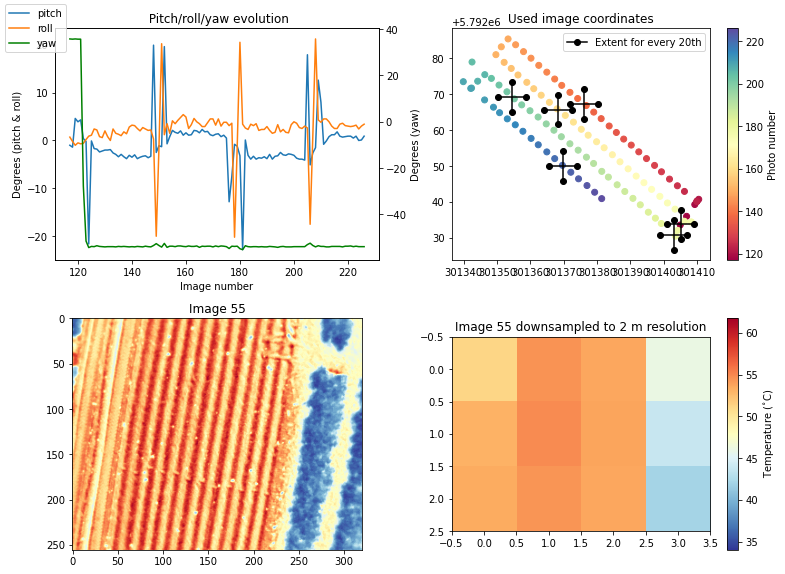

In [96]:
## Get image dataframe with corresponding properties extracted frpm path file
fileTypes = ('.jpg','.png','.tif') if imageType else ('.npy')
imgs = [_ for _ in glob.glob(imgDir+'*.*') if _.endswith(fileTypes)]
imgs.sort()
# Extract date and time from filenames
imgdates = [re.search('/20(.+?)_', path).group(1) for path in imgs] # Extract date from filename
imgtimes = [re.search('_(.+?)_', path).group(1) for path in imgs] # Extract time from filename
# Convert to unix datetime 
imgdatetimes = np.array([(datetime.timestamp(datetime(int('20'+imgdates[i][:2]),int(imgdates[i][2:4]),int(imgdates[i][4:6]),int(imgtimes[i][:2])+utcDiff,int(imgtimes[i][2:4]),int(imgtimes[i][4:6])))) for i in range(len(imgs))])*1000

# Imprt paths and get corresponding timestamps for images
pathDf = pd.read_csv(pathFile)
# Get nearest GPS timestamp
gpstimes = [min(pathDf['timestamp'], key=(lambda list_value : abs(list_value - i))) for i in imgdatetimes]

# Create image dataframe
imgDf = pd.DataFrame(data=np.array([imgs,gpstimes]).transpose(),columns=['imgPath','timestamp'])
imgDf['timestamp'] = imgDf['timestamp'].astype(float)

# Merge with path dataframe
merged = imgDf.merge(pathDf[pathColumns], on='timestamp', how='left')
# Filter for acceptable measurement altitudes
merged = merged.loc[(merged[altCol] > minAlt) & (merged[altCol] < maxAlt)]
if imgTimes: merged = merged.loc[(merged['timestamp'] > imgTimes[0]) & (merged['timestamp'] < imgTimes[1])]

# Convert coordinates to UTM
myProj = Proj('+proj=utm +zone='+utmZone+', +'+hemisphere+' +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
merged['x'], merged['y'] = myProj(merged['longitude'].values, merged['latitude'].values)

# Display example
merged.head()

distFilt = 4 # Filter out images where angle is high

fig, axs = plt.subplots(2,2,figsize=[11,8])
# Pitch/roll/yaw plot
axs[0,0].plot(merged.index,merged['pitch(deg)'],label='pitch')
axs[0,0].plot(merged.index,merged['roll(deg)'],label='roll')
par1 = axs[0,0].twinx()
par1.plot(merged.index,merged['yaw(deg)'],c='g',label='yaw')
axs[0,0].set_title(' Pitch/roll/yaw evolution')
axs[0,0].set_xlabel('Image number'), axs[0,0].set_ylabel('Degrees (pitch & roll)')
par1.set_ylabel('Degrees (yaw)')
fig.legend(loc='upper left')

# Coordinate corrections
# Angle corrected
dist = merged['altitude(m)']*np.tan(np.deg2rad(merged['pitch(deg)']))
merged['xc'], merged['yc'] = merged.x+(dist*np.sin(np.deg2rad(merged['yaw(deg)']))), merged.y+(dist*np.cos(np.deg2rad(merged['yaw(deg)'])))
if distFilt: idf = merged[abs(dist) < distFilt]
else: idf = merged.copy()
    
## Plot flight path with an example image and downscale
# Plot example image
imageNum = int(len(merged.index)/2)
arr = hf.img_to_arr(merged.iloc[imageNum]['imgPath'])
yCoords, xCoords = [(np.array(range(arr.shape[i]))-(arr.shape[i]/2))*pxSize+pxSize/2 for i in [0,1]]
if useCentre: xq, yq = int(np.floor(len(xCoords)/4)), int(np.floor(len(yCoords)/4))
else: xq, yq = False, False
arr = hf.img_to_arr(merged.iloc[imageNum]['imgPath'], xq=xq, yq=yq)
a = axs[1,0].imshow(arr, cmap=cmap)
axs[1,0].set_title('Image {}'.format(imageNum))

# Plot images to be used
b = axs[0,1].scatter(idf.xc,idf.yc,c=idf.index, cmap='Spectral')
size = np.array(arr.shape[:2])*pxSize/2
for i, row in idf[::skip].iterrows():
    axs[0,1].plot([row.x-size[1], row.x+size[1]], [row.y, row.y],'k-o')
    axs[0,1].plot([row.x, row.x],[row.y-size[1], row.y+size[1]],'k-o')
axs[0,1].set_title('Used image coordinates')
axs[0,1].legend(labels=['Extent for every {}th'.format(skip)])
fig.colorbar(b, ax=axs[0,1],label='Photo number')

# Plot example downsampled image
ds_array = hf.downsample_arr(arr, pxSize, resolution)
c = axs[1,1].imshow(ds_array) if imageType else axs[1,1].imshow(ds_array, vmin=arr.min(), vmax=arr.max(),cmap=cmap)
axs[1,1].set_title('Image {} downsampled to {} m resolution'.format(str(imageNum),resolution))
if imageType is False: fig.colorbar(c, ax=axs[1,1], label=' Temperature ($^{\circ}$C)')
fig.tight_layout()
plt.show()

In [97]:
merged

,imgPath,timestamp,latitude,longitude,altitude(m),pitch(deg),roll(deg),yaw(deg),x,y,xc,yc
117,data/12/20210719_130137_R.npy,1.626696e+12,52.242825,0.091087,11.8,-1.0,0.7,35.7,301405.149783,5.792034e+06,301405.029591,5.792034e+06
118,data/12/20210719_130138_R.npy,1.626696e+12,52.242848,0.091114,11.9,-1.4,-0.2,35.6,301407.095449,5.792036e+06,301406.926150,5.792036e+06
119,data/12/20210719_130139_R.npy,1.626696e+12,52.242869,0.091138,11.9,4.6,-1.0,35.7,301408.827410,5.792038e+06,301409.386122,5.792039e+06
120,data/12/20210719_130140_R.npy,1.626696e+12,52.242879,0.091149,12.0,3.9,-0.5,35.6,301409.622900,5.792040e+06,301410.099122,5.792040e+06
121,data/12/20210719_130141_R.npy,1.626696e+12,52.242883,0.091155,11.9,4.3,-0.7,35.6,301410.050306,5.792040e+06,301410.571170,5.792041e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
222,data/12/20210719_130322_R.npy,1.626696e+12,52.242943,0.090597,12.0,0.5,3.0,-54.0,301372.231304,5.792048e+06,301372.146582,5.792048e+06
223,data/12/20210719_130323_R.npy,1.626696e+12,52.242927,0.090633,12.0,0.9,3.2,-53.8,301374.617047,5.792046e+06,301374.464926,5.792046e+06
224,data/12/20210719_130324_R.npy,1.626696e+12,52.242912,0.090669,12.0,0.0,2.4,-54.0,301377.007260,5.792045e+06,301377.007260,5.792045e+06
225,data/12/20210719_130325_R.npy,1.626696e+12,52.242896,0.090704,12.0,0.1,3.0,-54.0,301379.324750,5.792043e+06,301379.307806,5.792043e+06


In [ ]:
# Try xy if you like

Lossy conversion from float64 to uint8. Range [315.07035194942586, 491.0603017624583]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 0/20 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [315.07035194942586, 491.0603017624583]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [312.4128514413206, 488.9094715092473]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [312.4128514413206, 488.9094715092473]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [312.6663548433488, 491.1625984962649]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [312.6663548433488, 491.1625984962649]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [304.639

Raw matches (Brute force): 189
59.25433027924905
Images 20 and 21 merged.
Raw matches (Brute force): 177
49.27081228027085
Images 21 and 22 merged.
Raw matches (Brute force): 161
51.573030538302085
Images 22 and 23 merged.
Raw matches (Brute force): 248
51.4908374886725
Images 23 and 24 merged.
Raw matches (Brute force): 185
58.83371928513036
Images 24 and 25 merged.


 30%|███       | 6/20 [00:00<00:00, 22.88it/s]Lossy conversion from float64 to uint8. Range [299.1097365244308, 476.31438462375746]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [304.8953220785151, 473.39920274630015]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [299.1097365244308, 476.31438462375746]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [285.29746313438056, 474.1288703989803]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [285.29746313438056, 474.1288703989803]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [283.05752787683537, 470.05612167168965]. Convert image to uint8 prior to saving to suppress this warning.
 45%|████▌     | 9/20 [00:00<00:00, 23.37

Raw matches (Brute force): 183
60.607014474597705
Images 25 and 26, poor matching
Raw matches (Brute force): 174
62.448617536448864
Images 25 and 27, poor matching
Raw matches (Brute force): 158
59.46391171791295
Images 25 and 28 merged.
Raw matches (Brute force): 176
62.19857286121303
Images 28 and 29, poor matching
Raw matches (Brute force): 144
57.56687419680467
Images 28 and 30 merged.


Lossy conversion from float64 to uint8. Range [295.48663957128696, 467.33078708315304]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [297.1710259422268, 470.05612167168965]. Convert image to uint8 prior to saving to suppress this warning.
 60%|██████    | 12/20 [00:00<00:00, 22.65it/s]Lossy conversion from float64 to uint8. Range [297.1710259422268, 470.05612167168965]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [306.43050205159125, 462.0665771959639]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [306.43050205159125, 462.0665771959639]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [305.0233756848786, 464.0705948382115]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. R

Raw matches (Brute force): 167
43.933461186186356
Images 30 and 31 merged.
Raw matches (Brute force): 184
43.828619376997025
Images 31 and 32 merged.
Raw matches (Brute force): 146
58.974805499814224
Images 32 and 34 merged.
Raw matches (Brute force): 168
55.999140921304814
Images 34 and 35 merged.
Raw matches (Brute force): 182
60.93905529587784
Images 35 and 36, poor matching


Lossy conversion from float64 to uint8. Range [303.10023321467764, 468.1702239307384]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [303.10023321467764, 468.1702239307384]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [305.9191297096554, 465.12355515308707]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [305.9191297096554, 465.12355515308707]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [305.9191297096554, 463.9652312163415]. Convert image to uint8 prior to saving to suppress this warning.
 95%|█████████▌| 19/20 [00:00<00:00, 23.34it/s]Lossy conversion from float64 to uint8. Range [305.9191297096554, 463.9652312163415]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Ran

Raw matches (Brute force): 139
57.3486559539588
Images 35 and 37 merged.
Raw matches (Brute force): 156
49.37148291211071
Images 37 and 38 merged.
Raw matches (Brute force): 271
14.418465459207884
Images 38 and 39 merged.
Raw matches (Brute force): 263
37.00730235714418
Images 39 and 40 merged.


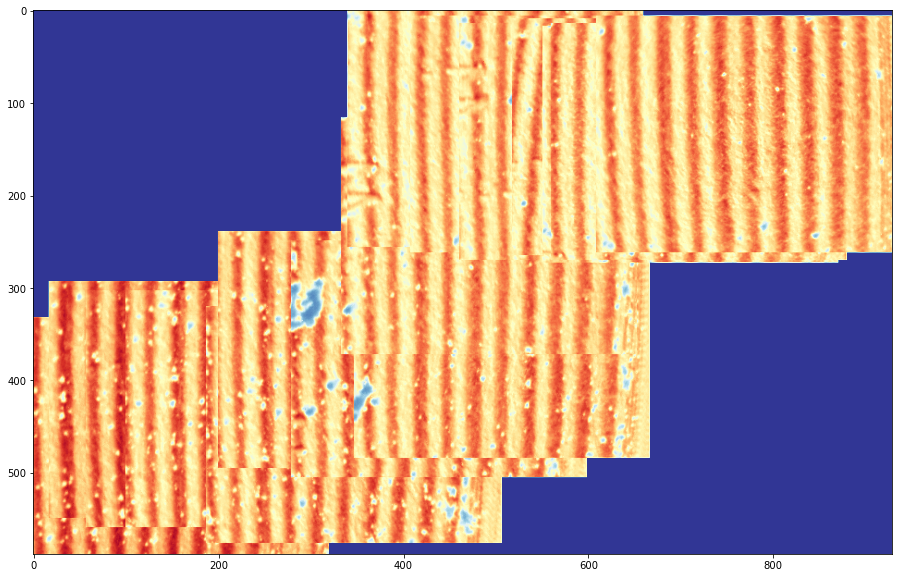

In [103]:
# Multi-image stitching
if 'result' in globals(): del(result)
# Setup variables
start = 20
end = 40
step = 1
skips = [33]#[17, 26,29,37,44,45,56]
xmin, xmax, ymin, ymax = 0,0,0,0

# Stitching properties
feature_extractor = 'orb'
feature_matching = 'bf'
tempfiles = ['temp0.jpg','temp1.jpg']
prev = start

arr = hf.img_to_arr(idf.iloc[start]['imgPath'], xq=xq, yq=yq)
single = ((arr+10)*255/40)
imageio.imwrite(tempfiles[0],np.dstack((single,single,single)))
prevImg = np.dstack((single,single,single)).astype(np.uint8)
totalBox=[prevImg.shape[0], prevImg.shape[1]]
prevBox=[0,prevImg.shape[0],0,prevImg.shape[1]]

for imgNum in tqdm(np.arange(start+step if start < end else start-step,end+1,step if start < end else -step)):
    if imgNum in skips:
        continue
    arrs = [hf.img_to_arr(idf.iloc[prev]['imgPath'], xq=xq, yq=yq),hf.img_to_arr(idf.iloc[imgNum]['imgPath'], xq=xq, yq=yq)]

    for i, val in enumerate(tempfiles): 
        single = ((arrs[i]+10)*255/40)
        imageio.imwrite(val,np.dstack((single,single,single)))
    # Read images - Make sure that the train image is the image that will be transformed
    trainImg, queryImg = [imageio.imread(i) for i in tempfiles]
    #for i in tempfiles: os.remove(i)
    # Opencv defines the color channel in the order BGR - transform it to RGB to be compatible to matplotlib
    trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]

    # Detect the keypoints and features on both images
    kpsA, featuresA = hf.detectAndDescribe(trainImg_gray, method=feature_extractor)
    kpsB, featuresB = hf.detectAndDescribe(queryImg_gray, method=feature_extractor)

    # Link  the identified features between images
    if feature_matching == 'bf':
        matches = hf.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    elif feature_matching == 'knn':
        matches = hf.matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)

    # Potential to improve by filtering out matches that are not in same direction of travel as drone
    ma = np.array([kpsA[j].pt for j in [i.queryIdx for i in matches]])
    mb = np.array([kpsB[j].pt for j in [i.trainIdx for i in matches]])

    # Filter by only matches in direction of travel
    xmov, ymov = idf.iloc[imgNum]['xc']-idf.iloc[prev]['xc'], idf.iloc[imgNum]['yc']-idf.iloc[prev]['yc']
    bothMov = 2
    if abs(xmov) < bothMov/2 and abs(ymov) < bothMov/2:
        mam, mbm = ma, mb
    else: 
        if abs(xmov) > abs(ymov):
            if xmov < 0:
                mam, mbm = ma[[ma[i,0]>mb[i,0] for i in range(len(ma))]], mb[[ma[i,0]>mb[i,0] for i in range(len(ma))]]
            else: mam, mbm = ma[[ma[i,0]>mb[i,0] for i in range(len(ma))]], mb[[ma[i,0]>mb[i,0] for i in range(len(ma))]]
        else:
            if ymov < 0:
                mam, mbm = ma[[ma[i,1]<mb[i,1] for i in range(len(ma))]], mb[[ma[i,1]<mb[i,1] for i in range(len(ma))]]
            else: mam, mbm = ma[[ma[i,1]>mb[i,1] for i in range(len(ma))]], mb[[ma[i,1]>mb[i,1] for i in range(len(ma))]]

    diff = np.median(mam-mbm, axis=0).astype(int)
  
    #------------------#    
    print(np.std(mam-mbm, axis=0).mean())
    if len(mam) > 10 and np.std(mam-mbm, axis=0).mean() < 60:
        # Work out new positions
        newBox=[int(np.round(prevBox[0]+diff[1])), int(np.round(prevBox[1]+diff[1])), int(np.round(prevBox[2]+diff[0])),int(np.round(prevBox[3]+diff[0]))] # New box position before adjustment for expanding total box

        pos = [0,0] # Position for previously merged images
        modBox = [0,0,0,0] # Position for new image
        # If bounds on axis 0 go beyond total
        if newBox[0]<0:
            xmin = imgNum
            totalBox[0]+=abs(newBox[0])
            modBox[1] = newBox[1]-newBox[0]
            modBox[0] = 0
            pos[0] = abs(newBox[0])
        elif newBox[1] > totalBox[0]:
            xmax=imgNum
            totalBox[0]=newBox[1]
            modBox[1] = newBox[1]
            modBox[0] = newBox[0]
            pos[0] = 0
        else: modBox[0], modBox[1], pos[0] = newBox[0], newBox[1], 0
        # If bounds on axis 1 go beyond total
        if newBox[2]<0:
            ymin=imgNum
            totalBox[1]+=abs(newBox[2])
            modBox[3] = newBox[3]-newBox[2]
            modBox[2] = 0
            pos[1] = abs(newBox[2])
        elif newBox[3] > totalBox[1]:
            ymax=imgNum
            totalBox[1] = newBox[3]
            modBox[3] = newBox[3]
            modBox[2] = newBox[2]
            pos[1] = 0
        else: modBox[2], modBox[3], pos[1] = newBox[2], newBox[3], 0    
        prevBox = modBox  
        
        single = (arrs[1]+10)*255/40
        queryImg = np.dstack((single,single,single)).astype(np.uint8)
        result = np.zeros([totalBox[0],totalBox[1],3])
        result[pos[0]:pos[0]+prevImg.shape[0],pos[1]:pos[1]+prevImg.shape[1],:] = prevImg
        result[modBox[0]:modBox[1], modBox[2]:modBox[3],:] = queryImg
        print('Images {} and {} merged.'.format(str(prev),str(imgNum)))
        prev=imgNum
        prevImg = result
    else: print('Images {} and {}, poor matching'.format(str(prev),str(imgNum)))
    
    
fig = plt.figure(figsize=(20,10))
plt.imshow(result.mean(axis=2),cmap=cmap)

In [ ]:
# Save as kmz
inputCoords = True
userInputCoords = np.array([[0.106680, 0.108845],[52.204120, 52.204950]])
pixels = 1024 * 10
cmap = colorbrewer.get_map('RdYlBu', 'diverging', 11, reverse=True).mpl_colormap
if inputCoords: conv = userInputCoords
else: conv = np.array(myProj([idf.iloc[xmin]['yc']-pxSize*(np.floor(queryImg.shape[0]/2)+0.5), idf.iloc[xmax]['yc']+pxSize*(np.floor(queryImg.shape[0]/2)+0.5)],
                       [idf.iloc[ymin]['xc']-pxSize*(np.floor(queryImg.shape[1]/2)+0.5), idf.iloc[ymax]['xc']+pxSize*(np.floor(queryImg.shape[1]/2)+0.5)], inverse=True))
fig, ax = hf.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                         urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                         pixels=pixels)

rot = ndimage.rotate(result.mean(axis=2), 90)
single = np.ma.masked_where(rot < 1e-1, rot)/255*40-10
cs = ax.imshow(single,extent=(conv[0].min(),conv[0].max(),conv[1].min(),conv[1].max()), cmap=cmap, vmin=single.min(),vmax=single.max())
ax.set_axis_off()
fig.savefig('original0-25.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
resolution = 6
fig, ax = hf.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                         urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                         pixels=pixels)
#ds = hf.downsample_arr(single,pxSize,resolution)
#single = rot/255*50-10
ds = np.ma.masked_where(abs(hf.downsample_arr(single.filled(),pxSize,resolution)) > 1e3, hf.downsample_arr(single,pxSize,resolution))
cs = ax.imshow(ds,extent=(conv[0].min(),conv[0].max(),conv[1].min(),conv[1].max()), cmap=cmap, vmin=single.min(),vmax=single.max())
ax.set_axis_off()
fig.savefig('downsample0-25.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
fig = plt.figure(figsize=(1.0, 4.0))
ax = fig.add_axes([0.07, 0.05, 0.27, 0.9])
cb = fig.colorbar(cs, cax=ax)
cb.set_label('Temperature ($^{\circ}$C)', rotation=-90, color='k', labelpad=20, fontsize=13)
fig.tight_layout()
fig.savefig('legend.png', format='png', bbox_inches = 'tight', pad_inches = 0.2) 

In [ ]:
#Flight Path
stop = 25
x, y = idf.longitude[:stop], idf.latitude[:stop]
fig, ax = hf.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                         urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                         pixels=pixels)
ax.plot(x,y,'k-',linewidth=2,label='raw')
ax.set_axis_off()
fig.savefig('path0-25.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
hf.make_kml(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
         urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
         figs=['overlay1.png', 'overlay2.png','path.png'], colorbar='legend.png',
         kmzfile='stitch_thermal.kmz', description=str(resolution)+'m resolution thermal imagery', name='Satellite resolution')

In [ ]:
# Save as .csv file
ds_arr = ds.shape
ptslon = np.linspace(conv[0].min(),conv[0].max(),ds_arr[1]+1)[:-1]
ptslon += (ptslon[1]-ptslon[0])/2
ptslat = np.linspace(conv[1].min(),conv[1].max(),ds_arr[0]+1)[:-1]
ptslat += (ptslat[1]-ptslat[0])/2
lonm, latm = np.meshgrid(ptslon,ptslat)

import pandas as pd
ds_q = int(np.floor(resolution/pxSize))
arr = np.round(single[:-(single.shape[0] % ds_q),:-(single.shape[1] % ds_q)]).astype(int)
most=np.zeros([len(range(0,arr.shape[0]-ds_q,ds_q))+1, len(range(0,arr.shape[1]-ds_q,ds_q))+1])
for i in range(0,arr.shape[0],ds_q):
    for j in range(0,arr.shape[1],ds_q):
        most[int(i/ds_q),int(j/ds_q)] = Counter(arr[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0]
        
tdf = pd.DataFrame(np.concatenate([np.flip(latm.reshape(-1,1)), lonm.reshape(-1,1), ds.reshape(-1,1), most.reshape(-1,1)], axis=1), columns=['Latitude', 'Longitude', '6m T(C)', '0.27cm T(C)'])
filt = tdf[ds.mask.reshape(-1,1) == False]
filt.to_csv('plots/stitch_temps.csv', index_label='UID')